In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from scipy.optimize import minimize

In [2]:
num_qubits = 12
num_layers = 4

def create_ising_hamiltonian(num_qubits, J=+1.0, h=+1.0):
    """Create cyclic transverse field Ising Hamiltonian"""
    # ZZ terms (cyclic)
    zz_terms = []
    for i in range(num_qubits):
        pauli_str = ['I']*num_qubits
        pauli_str[i] = 'Z'
        pauli_str[(i+1)%num_qubits] = 'Z'
        zz_terms.append(SparsePauliOp(''.join(pauli_str), coeffs=J))
    
    # X terms (transverse field)
    x_terms = []
    for i in range(num_qubits):
        pauli_str = ['I']*num_qubits
        pauli_str[i] = 'X'
        x_terms.append(SparsePauliOp(''.join(pauli_str), coeffs=h))
    
    return sum(zz_terms + x_terms)
    
hamiltonian = create_ising_hamiltonian(num_qubits)

In [3]:
ansatz = TwoLocal(
    num_qubits,
    rotation_blocks='ry',
    entanglement_blocks='cx',
    entanglement='circular',
    reps=num_layers,
    skip_final_rotation_layer=True,
    insert_barriers=True
)

In [4]:
def noiseless_cost(params):
    bound_circuit = ansatz.assign_parameters(params)
    
    transpiled = transpile(bound_circuit, backend_noiseless)
    transpiled.save_statevector()
    job = backend_noiseless.run(transpiled)
    result = job.result()
    statevector = result.get_statevector()
    
    return np.real(statevector.expectation_value(hamiltonian))

In [5]:
np.random.seed(0)
initial_params = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
backend_noiseless = AerSimulator(method='statevector')

In [6]:
result_noiseless = minimize(
    noiseless_cost,
    initial_params,
    method='L-BFGS-B',
    options={'maxiter': 100}
)

In [7]:
e_noiseless = result_noiseless.fun

optimized_params = result_noiseless.x
print(e_noiseless)
optimized_params

-15.04099962559642


array([-1.00202236,  1.66751374, -1.08169798,  1.87013087,  1.13781042,
        1.09606924, -1.06789025,  2.08310266,  2.08183039, -1.06319775,
        4.18298006,  1.80453319,  1.52170628,  2.24640365, -4.25468497,
       -1.28373027, -1.39154463,  1.46816893,  1.51417811,  1.54032293,
        1.55477132,  1.57878825, -1.57438705,  1.57039155, -1.95341889,
        1.48488874, -4.52434509,  1.62967346,  1.53782187, -1.55763075,
       -1.57750007,  1.57876548, -1.58286908,  1.56964849, -4.67913279,
        1.57306644,  1.57622087,  1.57654461,  1.56188792,  1.58445674,
       -1.59137961,  1.60091435,  1.52929676, -1.5218805 ,  1.53870964,
        1.52159265, -1.65001774, -1.56762551])

In [8]:
import qutip as qt

J = +1.0
h = +1.0

# Pauli matrices
X = qt.sigmax()
Z = qt.sigmaz()
I = qt.qeye(2)

# Initialize Hamiltonian terms
hamiltonian_terms = []

# Add cyclic ZZ terms
for i in range(num_qubits):
    zz_term = [J * qt.tensor([Z if j == i or j == (i+1)%num_qubits else I for j in range(num_qubits)])]
    hamiltonian_terms.extend(zz_term)

# Add X terms
for i in range(num_qubits):
    x_term = [h * qt.tensor([X if j == i else I for j in range(num_qubits)])]
    hamiltonian_terms.extend(x_term)

# Sum all terms
hamiltonian_qiskit = sum(hamiltonian_terms)
eigenvalues, eigenvectors = hamiltonian_qiskit.eigenstates()

In [9]:
gap = eigenvalues[1] - eigenvalues[0]
eigenvalues

array([-15.32259515, -15.19150823, -14.27838561, ...,  14.27838561,
        15.19150823,  15.32259515])

In [10]:
def cyclic_permutations(lst):
    n = len(lst)
    return [lst[i:] + lst[:i] for i in range(n)]

def run_noisy_cycle(num_qubits, num_layers, params, gammas):
    ansatz = TwoLocal(
        num_qubits,
        rotation_blocks='ry',
        entanglement_blocks='cx',
        entanglement='circular',
        reps=num_layers,
        skip_final_rotation_layer=True,
        insert_barriers=True
    )

    perms = cyclic_permutations(gammas)
    energies = []
    for perm in perms:
        noise_model = NoiseModel()
        for i in range(num_qubits):
            control, target = i, (i+1) % num_qubits
    
            error_control = amplitude_damping_error(perm[control])
            error_target = amplitude_damping_error(perm[target])
    
            cnot_error = error_control.tensor(error_target)
    
            noise_model.add_quantum_error(
                cnot_error,
                ['cx'],
                [control, target]
            )

            backend_noisy = AerSimulator(noise_model=noise_model, method='density_matrix')
            noisy_circuit = transpile(ansatz.assign_parameters(optimized_params), backend_noisy)
            noisy_circuit.save_density_matrix()
            result_noisy = backend_noisy.run(noisy_circuit).result()
            density_matrix = result_noisy.data()['density_matrix']
            noisy_energy = np.real(density_matrix.expectation_value(hamiltonian))


        energies.append(noisy_energy)

    return energies

In [11]:
from tqdm import tqdm

gamma_values1 = np.random.uniform(0.0, 0.01, num_qubits)
gamma_values2 = np.random.uniform(0.0, 0.01, num_qubits)
energies1 = []
energies2 = []
for i in tqdm(range(1, 21)):
    energies1.append(run_noisy_cycle(num_qubits, num_layers, optimized_params, list(i*gamma_values1)))
    energies2.append(run_noisy_cycle(num_qubits, num_layers, optimized_params, list(i*gamma_values2)))

100%|████████████████████████████████████████| 20/20 [5:13:18<00:00, 939.91s/it]


In [12]:
errors1 = [(i*gamma_values1).sum()*num_layers*2 for i in range(1, 21)]
errors2 = [(i*gamma_values2).sum()*num_layers*2 for i in range(1, 21)]

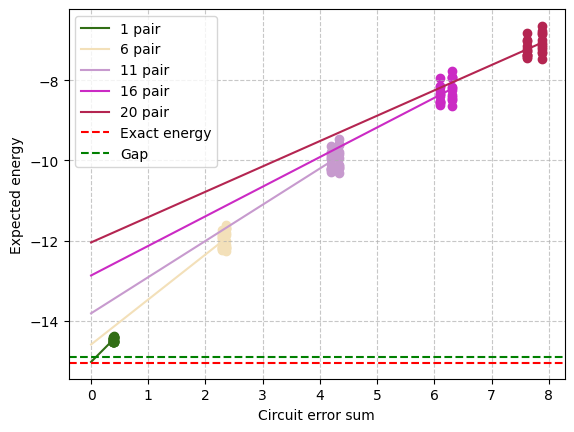

In [20]:
import matplotlib.pyplot as plt
import random

for i in [0, 5, 10, 15, 19]:
    r = random.random() 
    b = random.random() 
    g = random.random()

    color = (r, g, b) 
    
    plt.scatter([errors1[i]]*12, energies1[i], color=color)
    plt.scatter([errors2[i]]*12, energies2[i], color=color)

    if i % 5 == 0 or i == 19:
        x = np.array([errors1[i]]*12 + [errors2[i]]*12)
        y = list(energies1[i]) + list(energies2[i])

        m, b = np.polyfit(x, y, 1)

        x_regression = np.linspace(0, max(x), 100)
        regression_line = m * x_regression + b

        plt.plot(x_regression, regression_line, color=color, label=f'{i+1} pair')

plt.axhline(y=e_noiseless, color='red', label='Exact energy', linestyle='--')

plt.axhline(y=e_noiseless + gap, color='green', label='Gap', linestyle='--')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Circuit error sum')
plt.ylabel('Expected energy')
plt.legend()

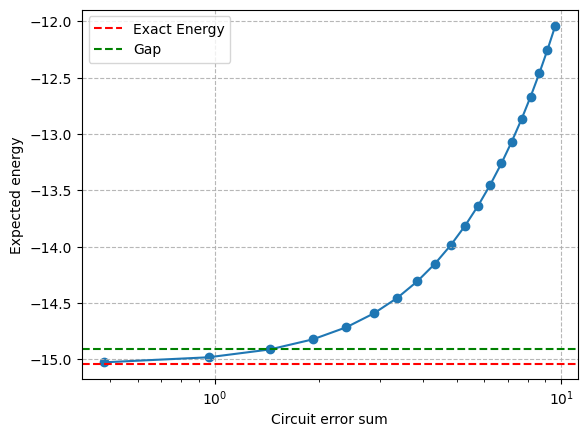

In [14]:
bs = []

plt.xscale("log")

for i in range(20):
    x = np.array([errors1[i]]*12 + [errors2[i]]*12)
    y = list(energies1[i]) + list(energies2[i])

    m, b = np.polyfit(x, y, 1)
    bs.append(b)

plt.plot([0.005 * (i + 1) * num_qubits * num_layers * 2 for i in range(20)], bs)
plt.scatter([0.005 * (i + 1) * num_qubits * num_layers * 2 for i in range(20)], bs)
plt.axhline(y=e_noiseless, color='red', label='Exact Energy', linestyle='--')

plt.axhline(y=e_noiseless + gap, color='green', label='Gap', linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.grid(axis='x', linestyle='--', alpha=0.9)
plt.xlabel('Circuit error sum')
plt.ylabel('Expected energy')
plt.legend()

In [15]:
data = []
for i in range(1, 21):
    data.append({
                'gammas_1': list(i*gamma_values1),
                'gammas_2': list(i*gamma_values2),
                'energies_1': energies1[i-1],
                'energies_2': energies2[i-1]}
               )

In [16]:
import json
with open('data1.json', 'w') as f:
    json.dump(data, f)

In [17]:
print(optimized_params)

[-1.00202236  1.66751374 -1.08169798  1.87013087  1.13781042  1.09606924
 -1.06789025  2.08310266  2.08183039 -1.06319775  4.18298006  1.80453319
  1.52170628  2.24640365 -4.25468497 -1.28373027 -1.39154463  1.46816893
  1.51417811  1.54032293  1.55477132  1.57878825 -1.57438705  1.57039155
 -1.95341889  1.48488874 -4.52434509  1.62967346  1.53782187 -1.55763075
 -1.57750007  1.57876548 -1.58286908  1.56964849 -4.67913279  1.57306644
  1.57622087  1.57654461  1.56188792  1.58445674 -1.59137961  1.60091435
  1.52929676 -1.5218805   1.53870964  1.52159265 -1.65001774 -1.56762551]


In [21]:
gamma_values1 = gamma_values1/10
gamma_values2 = gamma_values2/10

In [22]:
energies1small = []
energies2small = []
for i in tqdm([1, 5, 10, 15, 20]):
    energies1small.append(run_noisy_cycle(num_qubits, num_layers, optimized_params, list(i*gamma_values1)))
    energies2small.append(run_noisy_cycle(num_qubits, num_layers, optimized_params, list(i*gamma_values2)))

100%|██████████████████████████████████████████| 5/5 [1:18:55<00:00, 947.03s/it]


In [24]:
data_small = []
for i in range(1, 6):
    data_small.append({
                'gammas_1': list(i*gamma_values1),
                'gammas_2': list(i*gamma_values2),
                'energies_1': energies1small[i-1],
                'energies_2': energies2small[i-1]}
               )
    
import json
with open('datasmall.json', 'w') as f:
    json.dump(data_small, f)